In [ ]:
# Step 1: Install dependencies (if needed)
import os
import zipfile
import requests
import json

# Step 2: Define dataset URLs
urls = {
    "train_annotations": "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/tree-canopy-detection/dataset/train_annotations.json",
    "train_images": "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/tree-canopy-detection/dataset/train_images.zip",
    "evaluation_images": "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/tree-canopy-detection/dataset/evaluation_images.zip",
    "sample_answer": "https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/tree-canopy-detection/dataset/sample_answer.json",
}

# Step 3: Create data folder
os.makedirs("data", exist_ok=True)

# Step 4: Download files
def download_file(url, save_path):
    if not os.path.exists(save_path):
        print(f"Downloading {url} ...")
        r = requests.get(url, stream=True)
        with open(save_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    else:
        print(f"{save_path} already exists, skipping.")

download_file(urls["train_annotations"], "data/train_annotations.json")
download_file(urls["train_images"], "data/train_images.zip")
download_file(urls["evaluation_images"], "data/evaluation_images.zip")
download_file(urls["sample_answer"], "data/sample_answer.json")

# Step 5: Unzip image archives
def unzip_file(zip_path, extract_to):
    if os.path.exists(extract_to):
        print(f"{extract_to} already exists, skipping unzip.")
    else:
        print(f"Unzipping {zip_path} ...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

unzip_file("data/train_images.zip", "data/train_images")
unzip_file("data/evaluation_images.zip", "data/evaluation_images")

# Step 6: Quick checks
print("Train images:", len(os.listdir("data/train_images")))
print("Eval images:", len(os.listdir("data/evaluation_images")))

# Load annotations as JSON
with open("data/train_annotations.json", "r") as f:
    train_annotations = json.load(f)

print("Number of annotations:", len(train_annotations))
print("Sample keys:", list(train_annotations.keys())[:5])



import os, json, random, shutil
from pathlib import Path
import numpy as np
from pprint import pprint

# Paths (adjust if your files are in a subfolder)
ROOT = "/content/data"
DATA_ROOT = os.path.join(ROOT, "dataset")
os.makedirs(DATA_ROOT, exist_ok=True)

# Files expected in current Colab working dir
TRAIN_ZIP = os.path.join(ROOT, "train_images.zip")
EVAL_ZIP = os.path.join(ROOT, "evaluation_images.zip")
RAW_ANN = os.path.join(ROOT, "train_annotations.json")  # your annotation file
# output locations
IMG_DIR = os.path.join(DATA_ROOT, "images")
TRAIN_IMG_DIR = os.path.join(DATA_ROOT, "train")
VAL_IMG_DIR = os.path.join(DATA_ROOT, "val")

# unzip if needed
import zipfile
if os.path.exists(TRAIN_ZIP):
    print("Unzipping train_images.zip ...")
    with zipfile.ZipFile(TRAIN_ZIP, 'r') as z:
        z.extractall(TRAIN_IMG_DIR)
if os.path.exists(EVAL_ZIP):
    print("Unzipping evaluation_images.zip ...")
    with zipfile.ZipFile(EVAL_ZIP, 'r') as z:
        z.extractall(VAL_IMG_DIR)

# helper: collect all image files
def collect_images(base):
    exts = (".jpg", ".jpeg", ".png", ".tif", ".tiff")
    files = []
    for root, _, filenames in os.walk(base):
        for f in filenames:
            if f.lower().endswith(exts):
                files.append(os.path.relpath(os.path.join(root, f), start=DATA_ROOT))
    return sorted(files)

print("Train image dir:", TRAIN_IMG_DIR, "exists?", os.path.exists(TRAIN_IMG_DIR))


Unzipping data/train_images.zip ...
Unzipping data/evaluation_images.zip ...
Train images: 151
Eval images: 151
Number of annotations: 1
Sample keys: ['images']
Unzipping train_images.zip ...
Unzipping evaluation_images.zip ...
Train image dir: /content/data/dataset/train exists? True


In [ ]:
len(coco_full['images'])

150

In [ ]:
!pip install pycocotools comet_ml ultralytics transformers albumentations opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.0/780.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 97.4 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.3.2
    Uninstalling python-box-7.3.2:
      Successfully uninstalled python-box-7.3.2


In [ ]:
COCO_OUT_DIR = os.path.join(DATA_ROOT, "annotations")
os.makedirs(COCO_OUT_DIR, exist_ok=True)
COCO_TRAIN_JSON = os.path.join(COCO_OUT_DIR, "instances_train_coco.json")
COCO_VAL_JSON   = os.path.join(COCO_OUT_DIR, "instances_val_coco.json")
COCO_FULL_JSON  = os.path.join(COCO_OUT_DIR, "instances_full_coco.json")

IMAGES_TO_IGNORE = ['40cm_train_86', '10cm_train_33', '40cm_train_100']


# 1.0 = Normal, 2.0 = Double presence, 1.5 = 50% chance of being doubled
SAMPLING_WEIGHTS = {
    # Scene Types
    "agriculture": 2.0,
    "agriculture_plantation": 2.0,
    "plantation": 2.0,
    "urban_area": 1.5,
    "industrial": 1.25,
    "rural_area": 1.0,
    "open_field": 1.0,

    # Resolutions (Found in filename)
    "80cm": 3.0,
    "60cm": 2.5,
    "40cm": 2.0,
    "20cm": 1.25,
    "10cm": 1.0
}
def get_sampling_count(filename):
    """
    Calculates how many times an image should appear based on weights.
    Handles floats probabilistically (e.g., 1.5 => 1 copy guaranteed + 50% chance of 2nd).
    """
    weight = 1.0

    # Check filename against weights
    for key, w in SAMPLING_WEIGHTS.items():
        if key in filename.lower():
            # You can choose to Add weights or Multiply them.
            # Using max() or multiplication is usually best. Here we take the highest matching weight.
            weight = max(weight, w)

    # Separate integer and decimal parts
    base_count = int(weight)
    remainder = weight - base_count

    # Probabilistic addition
    if random.random() < remainder:
        return base_count + 1
    return base_count

def is_coco_format(d):
    return isinstance(d, dict) and "annotations" in d and "images" in d and "categories" in d

def convert_custom_to_coco(raw, images_base):
    categories = {}
    cats = []
    anns = []
    imgs = []

    # Global counters
    global_image_id = 1
    global_ann_id = 1
    cat_id_counter = 1

    print(f"Processing {len(raw.get('images', []))} raw images...")

    for i, img in enumerate(raw.get("images", [])):
        fname = img["file_name"]

        if fname in IMAGES_TO_IGNORE:
            print(f'>>> Skipping ignored file: {fname}')
            continue

        width = img.get("width")
        height = img.get("height")

        # --- DUPLICATION LOGIC START ---
        # Determine how many times to repeat this image
        repeats = get_sampling_count(fname)

        # Loop for the number of duplicates needed
        for _ in range(repeats):

            # Create a unique ID for this instance of the image
            current_image_id = global_image_id

            # Add image entry (Pointing to the SAME filename)
            imgs.append({
                "id": current_image_id,
                "file_name": fname,
                "width": width,
                "height": height
            })

            # Add annotations for this specific image copy
            for a in img.get("annotations", []):
                cname = a.get("class", "unknown")
                if cname not in categories:
                    categories[cname] = cat_id_counter
                    cats.append({"id": cat_id_counter, "name": cname})
                    cat_id_counter += 1

                seg = a.get("segmentation", [])
                if not seg: continue

                if isinstance(seg[0], list): segs = seg
                else: segs = [seg]

                if len(segs[0]) < 6: continue

                # Bbox calculation
                xs = segs[0][0::2]; ys = segs[0][1::2]
                x_min, y_min, x_max, y_max = min(xs), min(ys), max(xs), max(ys)
                bbox = [x_min, y_min, x_max - x_min, y_max - y_min]

                # Area calculation
                area = 0
                px = xs; py = ys
                for t in range(len(px)):
                    q = (t+1) % len(px)
                    area += px[t]*py[q] - px[q]*py[t]
                area = abs(area) / 2.0

                anns.append({
                    "id": global_ann_id, # Unique annotation ID
                    "image_id": current_image_id, # Links to the current duplicate
                    "category_id": categories[cname],
                    "segmentation": segs,
                    "area": area,
                    "bbox": bbox,
                    "iscrowd": 0
                })
                global_ann_id += 1

            # Increment image ID for the next duplicate or next file
            global_image_id += 1

        # --- DUPLICATION LOGIC END ---

    coco = {"images": imgs, "annotations": anns, "categories": cats}
    return coco

# Load raw JSON
with open(RAW_ANN, "r") as f:
    raw = json.load(f)

if is_coco_format(raw):
    print("Annotation file already in COCO format.")
    # write full copy
    with open(COCO_FULL_JSON, "w") as f:
        json.dump(raw, f)
    coco_full = raw
else:
    print("Converting custom format to COCO...")
    coco_full = convert_custom_to_coco(raw, TRAIN_IMG_DIR)
    with open(COCO_FULL_JSON, "w") as f:
        json.dump(coco_full, f)

print("Images found in annotation:", len(coco_full["images"]))
print("Annotations:", len(coco_full["annotations"]))
print("Categories:", coco_full["categories"])


Converting custom format to COCO...
Processing 150 raw images...
Images found in annotation: 266
Annotations: 86294
Categories: [{'id': 1, 'name': 'individual_tree'}, {'id': 2, 'name': 'group_of_trees'}]


In [ ]:
# Split by images
imgs = coco_full["images"]
anns = coco_full["annotations"]

random.seed(42)

img_ids = [img["id"] for img in imgs]
random.shuffle(img_ids)
split = int(0.8 * len(img_ids))
train_ids = set(img_ids[:])
val_ids = set(img_ids[split:])

def filter_coco(images, anns, keep_ids):
    imgs_f = [im for im in images if im["id"] in keep_ids]
    anns_f = [a for a in anns if a["image_id"] in keep_ids]
    return imgs_f, anns_f

train_imgs, train_anns = filter_coco(imgs, anns, train_ids)
val_imgs, val_anns = filter_coco(imgs, anns, val_ids)

cats = coco_full["categories"]

train_coco = {"images": train_imgs, "annotations": train_anns, "categories": cats}
val_coco   = {"images": val_imgs,   "annotations": val_anns,   "categories": cats}

with open(COCO_TRAIN_JSON, "w") as f:
    json.dump(train_coco, f)
with open(COCO_VAL_JSON, "w") as f:
    json.dump(val_coco, f)

print("Train images:", len(train_imgs), "Val images:", len(val_imgs))


Train images: 266 Val images: 54


In [ ]:
from ultralytics.data.converter import convert_coco
convert_coco("/content/data/dataset/annotations/",  # <-- correct param
    save_dir="/content/data/dataset/model/",       # root folder (creates images/, labels/)
    use_segments=True,                       # for instance segmentation
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Annotations /content/data/dataset/annotations/instances_full_coco.json: 100% ━━━━━━━━━━━━ 266/266 84.5it/s 3.1s
Annotations /content/data/dataset/annotations/instances_train_coco.json: 100% ━━━━━━━━━━━━ 266/266 85.5it/s 3.1s
Annotations /content/data/dataset/annotations/instances_val_coco.json: 100% ━━━━━━━━━━━━ 54/54 96.9it/s 0.6s
COCO data converted successfully.
Results saved to /content/data/dataset/model


In [ ]:
!mv /content/data/dataset/model/labels/train_coco /content/data/dataset/model/labels/train
!mv /content/data/dataset/model/labels/val_coco /content/data/dataset/model/labels/val




In [ ]:
!cp -r /content/data/dataset/train /content/data/dataset/annotations
!cp -r /content/data/dataset/val /content/data/dataset/annotations

In [ ]:
!rm -rf /content/data/dataset/model/labels/full_coco

In [ ]:
from pathlib import Path
import os, shutil
DATASET_DIR = Path('/content/data/dataset/model/')
train_img_dir = DATASET_DIR / 'images' / 'train'
val_img_dir = DATASET_DIR / 'images' / 'val'

train_labels_dir = DATASET_DIR / 'labels' / 'train'
val_labels_dir = DATASET_DIR / 'labels' / 'val'
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)

ALL_IMAGES = [os.path.join('/content/data/dataset/annotations/train', i) for i in os.listdir('/content/data/dataset/annotations/train')]

for train_label in os.listdir(train_labels_dir):
  train_label_path = os.path.join(train_labels_dir, train_label)
  corresponding_image_path = os.path.join('/content/data/dataset/annotations/train', train_label.replace('.txt', '.tif'))
  shutil.copyfile(corresponding_image_path, train_img_dir / Path(corresponding_image_path).name)

for val_label in os.listdir(val_labels_dir):
  val_label_path = os.path.join(val_labels_dir, val_label)
  corresponding_image_path = os.path.join('/content/data/dataset/annotations/train', val_label.replace('.txt', '.tif'))
  shutil.copyfile(corresponding_image_path, val_img_dir / Path(corresponding_image_path).name)


In [ ]:
!rm -rf /content/data/train_images/__MACOSX

## model - main yolo code

In [ ]:
import os
import json
import shutil
import numpy as np
from tqdm import tqdm

# --- CONFIG ---
# Adjust these paths if needed
DATA_ROOT = "/content/data/dataset"
OUTPUT_BASE = "/content/data/dataset/model"

# JSON Paths
TRAIN_JSON = os.path.join(DATA_ROOT, "annotations/instances_full_coco.json") # Your Weighted Train JSON
VAL_JSON   = os.path.join(DATA_ROOT, "annotations/instances_val_coco.json")  # Your Standard Val JSON

# Source Image Dirs (Where the actual .jpg/.tif files are)
SRC_TRAIN_DIR = os.path.join(DATA_ROOT, "train")
SRC_VAL_DIR   = os.path.join(DATA_ROOT, "val")

# --- HELPER: Generator Function ---
# --- HELPER: Generator Function (FIXED) ---
def process_dataset(json_path, src_dir, img_out_dir, lbl_out_dir, is_train=True):
    if not os.path.exists(json_path):
        print(f"Skipping {json_path} (File not found)")
        return

    print(f"Processing {'TRAIN' if is_train else 'VAL'} from {json_path}...")

    with open(json_path, 'r') as f:
        data = json.load(f)

    # Create directories
    os.makedirs(img_out_dir, exist_ok=True)
    os.makedirs(lbl_out_dir, exist_ok=True)

    # Map Categories
    cat_id_to_yolo = {cat['id']: i for i, cat in enumerate(data['categories'])}

    # --- BUG FIX HERE ---
    # We must initialize keys using 'images', not 'annotations'
    img_id_to_anns = {img['id']: [] for img in data['images']}

    # Fill the dictionary
    for ann in data['annotations']:
        # Safety check: ensure the image_id actually exists in our map
        if ann['image_id'] in img_id_to_anns:
            img_id_to_anns[ann['image_id']].append(ann)

    for img in tqdm(data['images']):
        src_path = os.path.join(src_dir, img['file_name'])

        # Check if file exists, if not, try to find it
        if not os.path.exists(src_path):
            # Sometimes filenames in JSON have ./ prefix or different relative paths
            # You can add print(src_path) here to debug if files are skipped
            continue

        # --- FILENAME LOGIC ---
        fname_no_ext, ext = os.path.splitext(img['file_name'])

        if is_train:
            # TRAIN: Append ID to force uniqueness for duplicates
            unique_name = f"{fname_no_ext}_ID{img['id']}{ext}"
        else:
            # VAL: Keep original name (No duplicates needed)
            unique_name = img['file_name']

        dst_img_path = os.path.join(img_out_dir, unique_name)
        dst_lbl_path = os.path.join(lbl_out_dir, unique_name.replace(ext, ".txt"))

        # 1. Create Symlink
        if not os.path.exists(dst_img_path):
            try:
                os.symlink(src_path, dst_img_path)
            except OSError:
                shutil.copy(src_path, dst_img_path)

        # 2. Create Label File
        anns = img_id_to_anns.get(img['id'], [])
        h, w = img['height'], img['width']

        with open(dst_lbl_path, 'w') as f:
            for ann in anns:
                cls_idx = cat_id_to_yolo.get(ann['category_id'])
                if cls_idx is None: continue

                for poly in ann['segmentation']:
                    if len(poly) < 6: continue
                    poly_np = np.array(poly).reshape(-1, 2)

                    # Normalize
                    poly_np[:, 0] /= w
                    poly_np[:, 1] /= h
                    poly_np = np.clip(poly_np, 0, 1)

                    line = f"{cls_idx} " + " ".join([f"{x:.6f}" for x in poly_np.flatten()])
                    f.write(line + "\n")
# --- EXECUTION ---

# 1. Clean ONLY the target subdirectories (Safety First!)
train_img_out = os.path.join(OUTPUT_BASE, "images/train")
train_lbl_out = os.path.join(OUTPUT_BASE, "labels/train")
val_img_out   = os.path.join(OUTPUT_BASE, "images/val")
val_lbl_out   = os.path.join(OUTPUT_BASE, "labels/val")

print("Cleaning target directories...")
for d in [train_img_out, train_lbl_out]:
        #   , val_img_out, val_lbl_out]:
    if os.path.exists(d):
        shutil.rmtree(d)

# 2. Run Generation
# Restore Validation (Standard 1:1)
# process_dataset(VAL_JSON, SRC_VAL_DIR, val_img_out, val_lbl_out, is_train=False)

# Regenerate Training (Weighted Duplicates)
process_dataset(TRAIN_JSON, SRC_TRAIN_DIR, train_img_out, train_lbl_out, is_train=True)

print("Done! Validation restored and Training set regenerated with unique IDs.")

Cleaning target directories...
Processing TRAIN from /content/data/dataset/annotations/instances_full_coco.json...


100%|██████████| 266/266 [00:02<00:00, 116.14it/s]


Done! Validation restored and Training set regenerated with unique IDs.


In [ ]:
!nproc

1


In [ ]:
%%writefile model_data-seg.yaml
# Model Data

path: /content/data/dataset/model
train: images/train
val: images/val
test: images/val

names:
  0: individual_tree
  1: group_of_trees

# cls_weights: [1.0, 2.0]

Writing model_data-seg.yaml


In [ ]:
## for training

!COMET_API_KEY=6XrHQdMJwserguyG5YKe5EcV6 yolo train data=model_data-seg.yaml model=yolo11s-seg.pt imgsz=832 batch=16 epochs=100 amp=True degrees=30 flipud=0.5 cos_lr=true lr0=0.01 lrf=0.3 optimizer=AdamW fliplr=0.5 erasing=0.2 augment=true device=0 compile=true

In [ ]:
# /content/runs/segment/train2 could be continued post 65, max mask is .46 atm

# COMET_API_KEY=6XrHQdMJwserguyG5YKe5EcV6 yolo train   data=model_data-seg.yaml   model=yolo11n-seg.pt   imgsz=832   batch=4   epochs=350   device=0   amp=True   cache=False   cos_lr=true   mask_ratio=3   overlap_mask=False   box=8.0   scale=0.3   degrees=30   flipud=0.5   fliplr=0.5   mixup=0.15   hsv_h=0.02   hsv_s=0.7   hsv_v=0.4   erasing=0.2

In [ ]:

# COMET_API_KEY=6XrHQdMJwserguyG5YKe5EcV6 yolo train   data=model_data-seg.yaml   model=yolo11s-seg.pt   imgsz=960   batch=8   epochs=350   device=0   amp=True   cache=False   cos_lr=true   mask_ratio=3   overlap_mask=False   box=8.0   scale=0.3   degrees=30   flipud=0.5   fliplr=0.5   mixup=0.15   hsv_h=0.02   hsv_s=0.7   hsv_v=0.4   erasing=0.2
# train3 maxed out map50 -- this got us best score .411

!nvidia-smi

Thu Oct 30 22:47:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             53W /  400W |   37938MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# COMET_API_KEY=6XrHQdMJwserguyG5YKe5EcV6 yolo train   data=model_data-seg.yaml   model=yolo11m-seg.pt   imgsz=960   batch=8   epochs=100   device=0   amp=True   cache=False   cos_lr=true   mask_ratio=3   overlap_mask=False   box=8.0   scale=0.3   degrees=30   flipud=0.5   fliplr=0.5   mixup=0.15   hsv_h=0.02   hsv_s=0.7   hsv_v=0.4   erasing=0.2 cache=true

# hopefully final best one

In [ ]:
%%writefile predict.yaml
# YOLO Model Parameters / Overrides

source: '/content/data/evaluation_images' # Data Source from REPO_ROOT

# hardware
device: 'None'              # 'mps' = Apple Metal GPU | None = best fit available
workers: 0                 # keep small on macOS/MPS / Not really needed durign prect
amp: True                   # Automatic Mixed Precision (AMP) training, reduces memory usage

# dataloader
rect: True                 # train with mosaic/crop; keep True only for val/test

# augmentation (aerial imagery friendly)
stream:  True                 # yield one-by-one (lower GPU memory usage)
                                # stream = False | Output is a list of results
                                # stream = True | Output is a 'generator' that yeilds **1** results at a time

# schedule
# train3 = 640
imgsz: 960                # image size (default 640)
batch: 1

# NMS (used at val/test)
conf: 0.05                    # filter low-confidence preds early
iou: 0.60                    # merge more aggressively in NMS
max_det: 1200                  # cap kept detections per image


agnostic_nms: False           # dont merge across classes
retina_masks: True           # Masking requires alot of GPU memory

# organiser
name: 'predict_ Yolov11s'
project: runs/segment         # Output destination from REPO_ROOT
plots: False                  # don't draw plots every val
save: False                   # Dont write visualized images
save_txt: True                # write labels/seg polygons
save_conf: True
exist_ok: true


Overwriting predict.yaml


In [ ]:
import ultralytics
from ultralytics import YOLO
import numpy as np
import time
import yaml
from pathlib import Path
import torch

# Assign directory location
# REPO_ROOT = Path(__file__).resolve().parent.parent


# Load model parameters / overrides YAML
with open('predict.yaml', 'r') as f: # Modify overrides where necessary
    overrides = yaml.safe_load(f)

# Make YAML Paths Absolute
# for key in ("source", "project"):
#     if key in overrides:
#         overrides[key] = str((REPO_ROOT / overrides[key]).resolve())

# Load Trained Model Weights
# weights = REPO_ROOT / 'runs/segment/training_fastNMS12/weights/best.pt' # Weights from Train Model / Modify where necessary
# weights = Path('/content/runs/segment/train8/weights/best.pt')
weights = "/content/runs/segment/train4/weights/best.pt"
# weights = '/content/640px_yolo_till_endS.pt'
# Load Trained Model's Weights
model = YOLO(str(weights))

# Predictions from the model
with torch.inference_mode():
    predictions = model.predict(**overrides)

# State output location

# Stream = True
for last in predictions:
    pass
print("Saved to:", last.save_dir)

# Stream = False
# print("Outputs saved to:", predictions[0].save_dir)



image 1/150 /content/data/evaluation_images/10cm_evaluation_1.tif: 960x960 71 individual_trees, 8 group_of_treess, 12.9ms
image 2/150 /content/data/evaluation_images/10cm_evaluation_10.tif: 960x960 91 individual_trees, 34 group_of_treess, 13.2ms
image 3/150 /content/data/evaluation_images/10cm_evaluation_11.tif: 960x960 103 individual_trees, 57 group_of_treess, 13.2ms
image 4/150 /content/data/evaluation_images/10cm_evaluation_12.tif: 960x960 58 individual_trees, 43 group_of_treess, 17.8ms
image 5/150 /content/data/evaluation_images/10cm_evaluation_13.tif: 960x960 126 individual_trees, 13.5ms
image 6/150 /content/data/evaluation_images/10cm_evaluation_14.tif: 960x960 68 individual_trees, 13.7ms
image 7/150 /content/data/evaluation_images/10cm_evaluation_15.tif: 960x960 66 individual_trees, 1 group_of_trees, 16.6ms
image 8/150 /content/data/evaluation_images/10cm_evaluation_16.tif: 960x960 89 individual_trees, 12.7ms
image 9/150 /content/data/evaluation_images/10cm_evaluation_17.tif: 9

In [ ]:
# Packages
from pathlib import Path
import pandas as pd
import numpy as np
import json
from PIL import Image
import pandas as pd
from datetime import datetime

# Create paths
REPO_ROOT = Path.cwd()

CURRENT_DATETIME = datetime.now().strftime('%Y-%m-%d %H:%M')

# Prediction Annotations
# LABELS = REPO_ROOT / 'predict_Yolo11s_canopy_832_9_20250831' # Modify Prediction Txt annotations where necessary
LABELS = '/content/runs/segment/predict_ Yolov11s/labels'
#
IMGS = REPO_ROOT / '/content/data/evaluation_images'
OUT_JSON = REPO_ROOT / 'exports'/ str(CURRENT_DATETIME) / 'submission.json'



#---Define Functions---#

# Image Metadata
def get_meta(IMGS):

    meta_data = {}
    scene_type_default = "Unknown"

    if IMGS.exists():

        for p in Path(IMGS).iterdir():
            if p.suffix.lower() not in {".tif"}: # All images .tif
                continue
            file_name = p.name
            cm_resolution = str(file_name[0:2])

            with Image.open(p) as image: # Pillow / Pill package
                width, height = image.size

            meta_data[file_name] = {
                'file_name' : file_name,
                "width" : width,
                'height' : height,
                "cm_resolution" : cm_resolution,
                "scene_type" : scene_type_default

            }
    else:
      print('Error - IMGs Not Exist')
    return meta_data


# Get Annotations
def get_annotations(LABELS):
    annotations = []

    for txt_file in sorted(Path(LABELS).iterdir()):
        if txt_file.is_file() and txt_file.suffix.lower() == ".txt":
            image_name = txt_file.name

            with open(txt_file, 'r') as file:
                for line in file:
                    tokens = line.strip().split()

                    # Safety check: Ensure line has enough data
                    if len(tokens) < 5:
                        continue

                    # 1. Parse Class ID
                    class_id = int(tokens[0])

                    # 2. Extract Confidence (The last token)
                    confidence_level = float(tokens[-1])

                    # 3. Extract Coords (Everything in between)
                    # This unpacks everything between index 1 and the last element
                    coords = list(map(float, tokens[1:-1]))

                    # --- CRITICAL FIX: FILTER BAD POLYGONS ---
                    # A polygon needs at least 3 points (x,y) * 3 = 6 values.
                    # If len(coords) < 6, it's a point or a line, not a shape.
                    if len(coords) < 6:
                        continue
                    # -----------------------------------------

                    # 4. Group coords into pairs (x,y)
                    segmentation = [
                        (coords[i], coords[i+1])
                        for i in range(0, len(coords), 2)
                    ]

                    annotations.append({
                        "image": image_name,
                        "class": class_id,
                        "confidence_level": confidence_level,
                        "segmentation": segmentation
                    })

    return annotations


# Denormalise segmentations to pixels

def denorm_segmentation(seg, width, height, *, flatten=True, round_int=True):
    """
    seg: list of (x,y) pairs in [0,1]
    returns: flat pixel list [x1,y1,x2,y2,...] (default) or list of pairs
    """
    # If seg is already flat [x1,y1,...], turn into pairs
    if seg and not isinstance(seg[0], (list, tuple)):
        it = iter(seg)
        seg_pairs = list(zip(it, it))
    else:
        seg_pairs = seg

    out = []
    for x, y in seg_pairs:
        X = max(0.0, min(width  - 1, x * width))
        Y = max(0.0, min(height - 1, y * height))
        if round_int:
            X = int(round(X))
            Y = int(round(Y))
        if flatten:
            out.extend([X, Y])
        else:
            out.append((X, Y))
    return out


# Append annotations to images

def append_imgs_annotations(img_list, annot_list):
    # ensure each image has an annotations list
    for img in img_list:
        if "annotations" not in img or img["annotations"] is None:
            img["annotations"] = []

    for image in img_list:
        w, h = image["width"], image["height"]
        fname = image["file_name"]

        # all annots for this image
        matched = (a for a in annot_list if a["image"] == fname)

        for a in matched:
            seg_px = denorm_segmentation(a["segmentation"], w, h, flatten=True, round_int=True) # Denormalise Segemetation to Pixels

            image["annotations"].append({
                "class": a["class"],
                "confidence_score": float(a["confidence_level"]),  # or keep as formatted string if you prefer
                "segmentation": seg_px
            })

    return img_list


# class id
ID_to_Name = {
    0 : 'individual_tree',
    1 : 'group_of_trees'
}



#--Procedure--#
print('Get Meta Data')
meta = get_meta(IMGS) # Retrieve Meta Data
meta_2items = list(meta.items())[:1]
meta_2keys = list(meta)[:1]

print(f'Meta Data Items : {meta_2items}')

print(f'Meta Data Keys : {meta_2items}')


images = [] # Produce Images list

print('Append Meta Data To Images List')
for m in meta.values(): # Append Meta Data to Images List
    images.append({
        'file_name' : m['file_name'],
        'width' : m['width'],
        'height' : m['height'],
        'cm_resolution' : m['cm_resolution'],
        'scene_type' : m['scene_type'],
        'annotations' : []
    })


images_sorted = sorted(images, key=lambda x: x['file_name']) # Sort Images
print(f'images_sorted ')

print('Get Annotations')
annotations_list = get_annotations(LABELS) # Retrieve Annotations & Denormalise Segmentations to Pixels

for annot in annotations_list: # Clean Annotations
    # .txt suffix -> .tif
    annot['image'] = annot['image'][:-4] + '.tif'

    # map class id -> name
    annot['class'] = ID_to_Name.get(annot['class'], 'Unknown')

    # convert confidence_level -> percentage string
    annot['confidence_level'] = f"{annot['confidence_level']:.2f}"

if annotations_list and len(annotations_list[0]) > 0:
    print('Annotations List Completed')

appended_list = append_imgs_annotations(images_sorted, annotations_list) # Append Annotations to Images

print(f'Appended_list Outputed ')

predict_answer = {}
predict_answer = {'images' : appended_list}
print(f'Predict_Answer Formulated')


# Assign Scene Type from Sample Answer to Submission

# sample_answer_input = REPO_ROOT / 'exports/sample_answer.json' # Acquire Sample Answer path
sample_answer_input = Path('/content/data/sample_answer.json')
with open(sample_answer_input) as f: # Open Sample Answer Structure
    sample_answer = json.load(f)

sample_answer = sample_answer['images']


image_scenes = [] # Create list of images and associated 'scene_type'

for image in sample_answer:
    file_name = image.get('file_name') # GET each image's name
    scene_type = image.get('scene_type') # GET each image's scene_type

    image_scenes.append(  # Append to list
        {
            'filename':file_name,
            'scene_type':scene_type
        }
    )


pd.json_normalize(image_scenes) #-- Potential redunant code --#

image_scenes_df = pd.DataFrame(image_scenes) # Transform Image_scenes list into DF

scene_map = image_scenes_df.set_index('filename')['scene_type'].to_dict() # Restructure image_scenes DF

submission = predict_answer

print('Append scene_types to predict_answer')
# Update each image in submission['images']
for image in submission['images']:
    filename = image['file_name']
    if image['scene_type'] == "Unknown" and filename in scene_map:
        image['scene_type'] = scene_map[filename]



print('Export Submission')
# Rewrite Submission JSON File
OUT_JSON.parent.mkdir(parents=True, exist_ok=True)
with open(OUT_JSON, "w") as f:
    json.dump(submission, f, indent=2)


print(f"Export Submission Complete \
      Saved As: 'Submission' \
      Saved At : {OUT_JSON}")


Get Meta Data
Meta Data Items : [('10cm_evaluation_28.tif', {'file_name': '10cm_evaluation_28.tif', 'width': 1024, 'height': 1024, 'cm_resolution': '10', 'scene_type': 'Unknown'})]
Meta Data Keys : [('10cm_evaluation_28.tif', {'file_name': '10cm_evaluation_28.tif', 'width': 1024, 'height': 1024, 'cm_resolution': '10', 'scene_type': 'Unknown'})]
Append Meta Data To Images List
images_sorted 
Get Annotations
Annotations List Completed
Appended_list Outputed 
Predict_Answer Formulated
Append scene_types to predict_answer
Export Submission
Export Submission Complete       Saved As: 'Submission'       Saved At : /content/exports/2025-11-29 02:51/submission.json


In [ ]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# --- Bounding Box and IoU Functions ---

def polygon_to_bbox(segmentation):
    """Converts a flat segmentation polygon list [x1, y1, x2, y2, ...] to [xmin, ymin, xmax, ymax]."""
    x_coords = segmentation[0::2]
    y_coords = segmentation[1::2]
    if not x_coords or not y_coords:
        return None
    return [
        min(x_coords),
        min(y_coords),
        max(x_coords),
        max(y_coords)
    ]

def bbox_iou(boxA, boxB):
    """Calculates IoU of two bounding boxes [xmin, ymin, xmax, ymax]."""
    if boxA is None or boxB is None:
        return 0.0

    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    interArea = inter_width * inter_height

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def simplified_nms(annotations, iou_threshold):
    """
    Applies a simplified NMS to segmentation annotations.

    Since confidence scores are not provided, boxes are suppressed based purely on overlap.
    A box is suppressed if its IoU with any *previously processed* box is > iou_threshold.
    """
    if not annotations:
        return []

    # 1. Convert to bbox and pair with original annotation
    bbox_annotations = []
    for ann in annotations:
        bbox = polygon_to_bbox(ann['segmentation'])
        if bbox:
            bbox_annotations.append({'bbox': bbox, 'original_ann': ann})

    # 2. Sort annotations (arbitrarily, since no score is available)
    # Sorting by xmin here to ensure deterministic suppression order
    bbox_annotations.sort(key=lambda x: x['bbox'][0])

    # 3. Apply suppression
    keep_annotations = []
    for current_ann in bbox_annotations:
        is_suppressed = False
        current_bbox = current_ann['bbox']

        for kept_ann in keep_annotations:
            kept_bbox = kept_ann['bbox']
            iou = bbox_iou(current_bbox, kept_bbox)

            # Check for overlap only with boxes of the same class for better realism
            if iou > iou_threshold and current_ann['original_ann']['class'] == kept_ann['original_ann']['class']:
                is_suppressed = True
                break

        if not is_suppressed:
            keep_annotations.append(current_ann)

    # Return the original annotation objects for the retained boxes
    return [ann['original_ann'] for ann in keep_annotations]

# --- Plotting Function ---

def plot_image_annotations(ax, image_path, annotations, title, colors):
    """Plots a single image with its annotations using Matplotlib."""
    try:
        img = Image.open(image_path)
        img = img.convert('RGB')
    except FileNotFoundError:
        ax.text(0.5, 0.5, f"Image not found:\n{os.path.basename(image_path)}",
                ha='center', va='center', fontsize=8, color='red')
        ax.set_title(title, fontsize=8)
        ax.axis('off')
        return

    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

    # Draw each annotation
    for annotation in annotations:
        segmentation = annotation['segmentation']
        class_name = annotation['class']

        # Get color
        fill_color = colors[class_name]['fill']
        outline_color = colors[class_name]['outline']

        # Convert flat list to NumPy array and then to a closed polygon path
        points = np.array([(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)])

        # Draw polygon patch (for Matplotlib)
        polygon = patches.Polygon(
            points,
            closed=True,
            edgecolor=outline_color,
            facecolor=fill_color,
            linewidth=1,
            alpha=0.5 # Using alpha for visibility
        )
        ax.add_patch(polygon)

# --- Main Execution ---

# Load annotations
try:
    with open('submission.json', 'r') as f:
        data = json.load(f)
except FileNotFoundError:
    print("Error: 'submission.json' not found.")
    exit()

# Define IoU settings and colors
IOU_SETTINGS = [0.3, 0.4, 0.6]
COLORS = {
    'individual_tree': {'fill': 'lime', 'outline': 'green'},
    'group_of_trees': {'fill': 'blue', 'outline': 'darkblue'}
}
NUM_IMAGES_TO_PLOT = 10 # Plot 10 images, showing 4 variants for each (30 files total for NMS + 10 for original)

images_to_process = data['images'][:NUM_IMAGES_TO_PLOT]

# Set up the figure for plotting (1 row for original, 3 rows for NMS settings)
fig, axes = plt.subplots(
    nrows=len(IOU_SETTINGS) + 1,
    ncols=NUM_IMAGES_TO_PLOT,
    figsize=(NUM_IMAGES_TO_PLOT * 3, (len(IOU_SETTINGS) + 1) * 3)
)
fig.suptitle(f'NMS Comparison for First {NUM_IMAGES_TO_PLOT} Images', fontsize=16)

# Iterate over images and plot
for col_idx, image_data in enumerate(images_to_process):
    file_name = image_data['file_name']
    image_path = os.path.join('evaluation_images', file_name)
    original_annotations = image_data['annotations']

    # --- Row 1: Original Annotations ---
    plot_image_annotations(
        axes[0, col_idx],
        image_path,
        original_annotations,
        f"Original\n({os.path.basename(file_name)})",
        COLORS
    )

    # --- Remaining Rows: NMS Annotations ---
    for row_idx, iou_thresh in enumerate(IOU_SETTINGS, 1):
        # Apply NMS
        nms_annotations = simplified_nms(original_annotations, iou_thresh)

        # Plot result
        plot_image_annotations(
            axes[row_idx, col_idx],
            image_path,
            nms_annotations,
            f"NMS (IoU={iou_thresh}) - Kept: {len(nms_annotations)}",
            COLORS
        )

# Add a single legend for the plot
import matplotlib.lines as mlines
legend_elements = [
    mlines.Line2D([0], [0], color='green', marker='s', linestyle='', label='individual_tree'),
    mlines.Line2D([0], [0], color='blue', marker='s', linestyle='', label='group_of_trees')
]
fig.legend(handles=legend_elements, loc='upper right', title="Legend")

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle and legend
plt.show()

print(f"\nPlotted {NUM_IMAGES_TO_PLOT * (len(IOU_SETTINGS) + 1)} total subplots to the screen.")
print("Color coding: Green = individual_tree, Blue = group_of_trees (both with transparency).")
print("NMS is a simplified version, suppressing overlapping boxes based on class and IoU threshold.")
print("The script assumes 'evaluation_images' folder is in the same directory.")

In [ ]:
!zip -r /content/runs/segment/train_Yolo11s_canopy_832_4.zip /content/runs/segment/train_Yolo11s_canopy_832_4

  adding: content/runs/segment/train_Yolo11s_canopy_832_4/ (stored 0%)
  adding: content/runs/segment/train_Yolo11s_canopy_832_4/predictions.json (deflated 70%)
  adding: content/runs/segment/train_Yolo11s_canopy_832_4/results.csv (deflated 60%)
  adding: content/runs/segment/train_Yolo11s_canopy_832_4/weights/ (stored 0%)
  adding: content/runs/segment/train_Yolo11s_canopy_832_4/weights/epoch10.pt (deflated 44%)
  adding: content/runs/segment/train_Yolo11s_canopy_832_4/weights/best.pt (deflated 11%)
  adding: content/runs/segment/train_Yolo11s_canopy_832_4/weights/epoch30.pt (deflated 45%)
  adding: content/runs/segment/train_Yolo11s_canopy_832_4/weights/last.pt (deflated 11%)
  adding: content/runs/segment/train_Yolo11s_canopy_832_4/weights/epoch0.pt (deflated 44%)
  adding: content/runs/segment/train_Yolo11s_canopy_832_4/weights/epoch20.pt (deflated 45%)
  adding: content/runs/segment/train_Yolo11s_canopy_832_4/args.yaml (deflated 53%)


In [ ]:
del model
import gc
gc.collect()
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.6 MB/s eta 0:00:00


## MRCNN - Not Useful

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import functional as F
from PIL import Image
import numpy as np
import os
from pycocotools.coco import COCO
import sys

# Get device (GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define paths (based on your initial script and common practice)
# We assume COCO format annotation files exist in the main dataset folder.
DATASET_DIR = '/content/data/dataset/model'
TRAIN_IMG_DIR = os.path.join(DATASET_DIR, 'images/train')
VAL_IMG_DIR = os.path.join(DATASET_DIR, 'images/val')
TRAIN_ANN_PATH = '/content/data/dataset/annotations/instances_train_coco.json' # Adjust if your file is named differently
VAL_ANN_PATH = '/content/data/dataset/annotations/instances_val_coco.json'   # Adjust if your file is named differently

# Number of classes (background + individual_tree + group_of_trees)
NUM_CLASSES = 1 + 2

In [ ]:
class CocoDataset(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Index corresponds to a specific image ID
        coco_id = self.ids[index]
        img_info = self.coco.loadImgs(coco_id)[0]
        ann_ids = self.coco.getAnnIds(imgIds=coco_id)
        coco_annotations = self.coco.loadAnns(ann_ids)

        # Load image
        path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(path).convert("RGB")

        # Prepare targets (Mask R-CNN expects targets as dict)
        num_objs = len(coco_annotations)
        boxes = []
        labels = []
        masks = []

        # COCO annotations contain bounding box, segmentation, and category_id
        for ann in coco_annotations:
            # Bounding box (format [xmin, ymin, w, h] in COCO)
            xmin = ann['bbox'][0]
            ymin = ann['bbox'][1]
            xmax = xmin + ann['bbox'][2]
            ymax = ymin + ann['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])

            # Labels (COCO is 1-indexed, so is our custom class map, but ensure consistency)
            # You might need to map COCO category_id to your 1, 2, ...
            # Assuming your COCO JSON categories map to 1 and 2 for individual_tree and group_of_trees
            labels.append(ann['category_id'])

            # Masks (COCO format: RLE or polygon; here we use COCO API to convert to binary mask)
            # This requires pycocotools installed: pip install pycocotools
            # Using the COCO API to generate a mask from RLE/Polygons
            mask_rle = self.coco.annToMask(ann)
            masks.append(mask_rle)

        # Convert to Tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8) # Stack masks into (N, H, W)

        # Create target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = torch.tensor([coco_id])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64) # Assuming not using crowd annotations

        # Apply transforms if any
        if self.transforms is not None:
            img = self.transforms(img)
            # NOTE: For object detection, transforms are usually applied to both image and target

        return img, target

    def __len__(self):
        return len(self.ids)

In [ ]:
# Simple transform that converts a PIL image to a PyTorch Tensor
def get_transform(train):
    transforms = []
    # Convert PIL Image to PyTorch Tensor
    transforms.append(F.to_tensor)

    # You would add data augmentation here for training (e.g., random flip, color jitter)
    if train:
        pass # Add custom transforms here if needed

    return lambda img: F.to_tensor(img)

# Collate function needed for DataLoader with variable-size tensors (like masks/boxes)
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def get_model_instance_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    model = maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained box predictor with a new one
    # num_classes is 1 (background) + number of custom classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # Replace the pre-trained mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.transforms import functional as F
from PIL import Image
import numpy as np
import os
import sys
import math
from pycocotools.coco import COCO
from torch.cuda.amp import GradScaler, autocast

# --- Configuration Constants ---
# Get device (GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Number of classes (background + individual_tree + group_of_trees)
NUM_CLASSES = 1 + 2

# Define paths (Adjust if needed)
DATASET_DIR = '/content/data/dataset/model'
TRAIN_IMG_DIR = os.path.join(DATASET_DIR, 'images/train')
VAL_IMG_DIR = os.path.join(DATASET_DIR, 'images/val')
# Assuming COCO JSON annotation files
TRAIN_ANN_PATH = '/content/data/dataset/annotations/instances_train_coco.json'
VAL_ANN_PATH = '/content/data/dataset/annotations/instances_val_coco.json'

# High-Performance Hyperparameters
BASE_LR = 0.005          # Scaled for a smaller batch size (e.g., 4)
NUM_EPOCHS = 20          # Longer training for high accuracy
PRINT_FREQ = 50          # Log every 50 iterations
WARMUP_ITERS = 500       # Warmup period iterations

# --- 1. Custom Dataset Class (COCO Format) ---

class CocoDataset(Dataset):
    """
    A PyTorch Dataset class designed to load data using COCO annotations.
    """
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        coco_id = self.ids[index]
        img_info = self.coco.loadImgs(coco_id)[0]
        ann_ids = self.coco.getAnnIds(imgIds=coco_id)
        coco_annotations = self.coco.loadAnns(ann_ids)

        path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(path).convert("RGB")

        num_objs = len(coco_annotations)
        boxes = []
        labels = []
        masks = []

        for ann in coco_annotations:
            # Bounding box (format [xmin, ymin, w, h] in COCO) -> [xmin, ymin, xmax, ymax]
            xmin = ann['bbox'][0]
            ymin = ann['bbox'][1]
            xmax = xmin + ann['bbox'][2]
            ymax = ymin + ann['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])

            # Assuming COCO category_id maps directly to 1 or 2
            labels.append(ann['category_id'])

            # Use pycocotools to convert RLE/polygon to binary mask
            mask_rle = self.coco.annToMask(ann)
            masks.append(mask_rle)

        # Convert to Tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks), dtype=torch.uint8) # Stack masks into (N, H, W)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = torch.tensor([coco_id])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)

# --- 2. Utility Functions ---

# Simple transform (PIL to PyTorch Tensor)
def get_transform(train):
    return lambda img: F.to_tensor(img)

# Collate function needed for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

# --- 3. High-Accuracy Model Definition (ResNet-101 FPN) ---

def get_model_instance_segmentation_high_accuracy(num_classes):
    # Use ResNet-101 backbone for higher feature richness
    backbone = resnet_fpn_backbone('resnet101', weights='IMAGENET1K_V1', trainable_layers=5)

    # Instantiate the model with the high-performance backbone
    model = MaskRCNN(backbone, num_classes=num_classes)

    # The default MaskRCNN constructor correctly handles the box and mask predictors
    # based on the provided num_classes, but we ensure the mask predictor is explicitly set:
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

# --- 4. High-Performance Training Function ---

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler, warmup_iters):
    model.train()

    header = 'Epoch: [{}]'.format(epoch)
    total_iters = len(data_loader)

    for i, (images, targets) in enumerate(data_loader):
        # --- LR Warmup Logic ---
        if epoch == 0 and i < warmup_iters:
            current_iter = i
            base_lr = optimizer.param_groups[0]["initial_lr"] # Access initial_lr set in optimizer

            # Linearly scale LR from near-zero to the base_lr
            lr_scale = float(current_iter) / float(warmup_iters)
            new_lr = base_lr * lr_scale

            for param_group in optimizer.param_groups:
                param_group["lr"] = new_lr

        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # --- Forward Pass with AMP ---
        with autocast(enabled=scaler is not None):
            # Model returns a dictionary of losses during training
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # --- Loss Sanity Check ---
        loss_value = losses.item()
        if not torch.isfinite(losses):
            print(f"WARNING: Loss became NaN/Inf at epoch {epoch}, iteration {i}. Stopping training.")
            sys.exit(1)

        # --- Backward Pass & Optimization (using scaler for AMP) ---
        optimizer.zero_grad()
        if scaler is not None:
            # Use scaler for mixed precision
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard backpropagation
            losses.backward()
            optimizer.step()

        # --- Detailed Logging ---
        if i % print_freq == 0:
            log_str = f"{header} | Iter: {i}/{total_iters} | Total Loss: {loss_value:.4f}"
            for name, loss in loss_dict.items():
                log_str += f" | {name}: {loss.item():.4f}"

            current_lr = optimizer.param_groups[0]["lr"]
            log_str += f" | LR: {current_lr:.6f}"

            print(log_str)


# --- 5. Main Execution Function ---

def main():
    # --- 1. Load Data ---
    dataset = CocoDataset(TRAIN_IMG_DIR, TRAIN_ANN_PATH, get_transform(train=True))
    dataset_val = CocoDataset(VAL_IMG_DIR, VAL_ANN_PATH, get_transform(train=False))

    data_loader = DataLoader(
        dataset, batch_size=6, shuffle=True, num_workers=0, # Increased batch size to 4
        collate_fn=collate_fn
    )

    data_loader_val = DataLoader(
        dataset_val, batch_size=1, shuffle=False, num_workers=0,
        collate_fn=collate_fn
    )

    # --- 2. Load Model (High-Accuracy: ResNet-101 FPN) ---
    model = get_model_instance_segmentation_high_accuracy(NUM_CLASSES)
    model.to(device)
    # model = torch.compile(model, mode="max-autotune")

    # --- 3. Optimizer and LR Scheduler ---
    params = [p for p in model.parameters() if p.requires_grad]

    # Store initial LR in the parameter group for the warmup calculation
    optimizer = optim.SGD(
        params, lr=BASE_LR, momentum=0.9, weight_decay=0.0001
    )
    for param_group in optimizer.param_groups:
        param_group["initial_lr"] = BASE_LR

    # MultiStepLR for precise decay
    lr_steps = [int(0.66 * NUM_EPOCHS), int(0.9 * NUM_EPOCHS)]
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=lr_steps, gamma=0.1
    )

    # --- 4. Initialize Grad Scaler for Mixed Precision (AMP) ---
    scaler = GradScaler()

    # --- 5. Training Loop ---
    print(f"Starting training on {device} with ResNet-101, AMP, and LR Warmup.")
    for epoch in range(NUM_EPOCHS):
        train_one_epoch(
            model,
            optimizer,
            data_loader,
            device,
            epoch,
            PRINT_FREQ,
            scaler=scaler,
            warmup_iters=WARMUP_ITERS
        )

        # Apply scheduler step only after the warmup phase is completed (usually after epoch 0)
        # We manually update LR during warmup, so we rely on the condition below:
        if epoch > 0 or WARMUP_ITERS >= len(data_loader):
            lr_scheduler.step()

        # Optional: Run evaluation here

    # --- 6. Save Model ---
    torch.save(model.state_dict(), 'maskrcnn_final_high_accuracy.pth')
    print("Training complete. Model saved.")

# if __name__ == '__main__':
#     # Ensure all dependencies (torch, torchvision, pycocotools) are installed
#     # and COCO JSON annotation files are correctly generated before running.
#     # main()
#     print("\nCode is ready. Uncomment 'main()' to execute the training process.")

In [ ]:
main()

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/tmp/ipython-input-3705735362.py:227: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting training on cuda with ResNet-101, AMP, and LR Warmup.


/tmp/ipython-input-3705735362.py:153: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=scaler is not None):


Epoch: [0] | Iter: 0/25 | Total Loss: 4.4813 | loss_classifier: 1.0872 | loss_box_reg: 0.1856 | loss_mask: 1.7857 | loss_objectness: 0.6899 | loss_rpn_box_reg: 0.7329 | LR: 0.000000
Epoch: [1] | Iter: 0/25 | Total Loss: 3.0259 | loss_classifier: 0.9101 | loss_box_reg: 0.1128 | loss_mask: 0.6242 | loss_objectness: 0.6912 | loss_rpn_box_reg: 0.6875 | LR: 0.000240
Epoch: [2] | Iter: 0/25 | Total Loss: 2.4855 | loss_classifier: 0.5685 | loss_box_reg: 0.1615 | loss_mask: 0.5976 | loss_objectness: 0.6943 | loss_rpn_box_reg: 0.4636 | LR: 0.000240
Epoch: [3] | Iter: 0/25 | Total Loss: 2.4859 | loss_classifier: 0.5896 | loss_box_reg: 0.0612 | loss_mask: 0.4922 | loss_objectness: 0.6815 | loss_rpn_box_reg: 0.6614 | LR: 0.000240
Epoch: [4] | Iter: 0/25 | Total Loss: 2.0615 | loss_classifier: 0.5136 | loss_box_reg: 0.0046 | loss_mask: 0.4698 | loss_objectness: 0.6892 | loss_rpn_box_reg: 0.3842 | LR: 0.000240
Epoch: [5] | Iter: 0/25 | Total Loss: 1.8610 | loss_classifier: 0.3619 | loss_box_reg: 0.0

Loading weights from /content/maskrcnn_final_high_accuracy.pth...

--- Starting Prediction (Score Threshold: 0.01) ---

Processing Image: /content/data/evaluation_images/10cm_evaluation_10.tif
Found 100 objects (Pre-Filtering).
Applied Manual NMS (IoU=0.3): 61 objects kept.


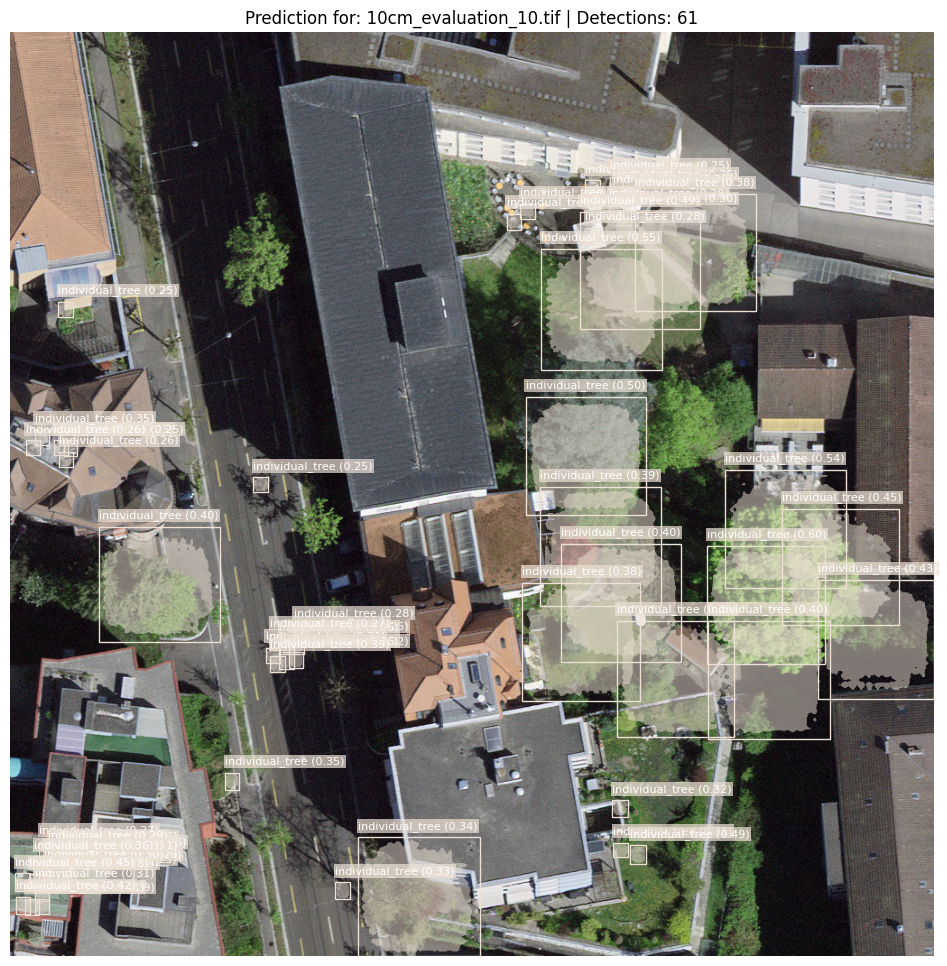

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision.transforms as T
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# --- Configuration Constants ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 1 + 2

MODEL_PATH = '/content/maskrcnn_final_high_accuracy.pth'
INFERENCE_IMAGE_PATHS = [
    '/content/data/evaluation_images/10cm_evaluation_10.tif',
]
SCORE_THRESHOLD = 0.01
CLASS_NAMES = {1: 'individual_tree', 2: 'group_of_trees'}
IOU_THRESHOLD_NMS = 0.3 # Custom IoU threshold for filtering

# --- 0. IoU Utility Functions ---

def box_iou(boxes1, boxes2):
    """Calculates the Intersection over Union (IoU)."""
    boxes1 = torch.tensor(boxes1, dtype=torch.float32)
    boxes2 = torch.tensor(boxes2, dtype=torch.float32)

    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    area1 = area1[:, None]
    area2 = area2[None, :]

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])

    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]

    iou = inter / (area1 + area2 - inter)

    return iou.cpu().numpy()

def non_max_suppression_fast(boxes, scores, iou_threshold):
    """
    Applies Non-Maximum Suppression (NMS) on bounding boxes.
    This is a NumPy implementation based on the fast NMS approach.
    """
    if len(boxes) == 0:
        return []

    # If the bounding boxes are integers, convert them to floats
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # Unpack the coordinates
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # Compute the area of the bounding boxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Sort the detection scores in descending order
    idxs = np.argsort(scores)[::-1]

    # Initialize the list of picked indices
    pick = []

    while len(idxs) > 0:
        # Grab the last index (highest score) and add it to the pick list
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the intersection coordinates
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Calculate intersection width and height
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Calculate the ratio of intersection over union (IoU)
        overlap = (w * h) / (area[idxs[:last]] + area[i] - (w * h))

        # Delete all indices where overlap is greater than the IoU threshold
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > iou_threshold)[0])))

    return pick

# --- 1. Model Definition (Must be identical to training) ---

def get_model_instance_segmentation_high_accuracy(num_classes):
    """Loads the Mask R-CNN ResNet-101 FPN model."""
    backbone = resnet_fpn_backbone('resnet101', weights='IMAGENET1K_V1', trainable_layers=5)
    model = MaskRCNN(backbone, num_classes=num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

# --- 2. Inference Function ---

def run_inference(model, image_path, device, threshold=0.01):
    """Loads an image, runs prediction, and filters results."""
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return None, None

    img = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(img).to(device)

    model.eval()

    with torch.no_grad():
        prediction = model([img_tensor])

    output = prediction[0]

    scores = output['scores']
    keep = scores >= threshold

    results = {
        'boxes': output['boxes'][keep].cpu().numpy(),
        'labels': output['labels'][keep].cpu().numpy(),
        'scores': scores[keep].cpu().numpy(),
        'masks': (output['masks'][keep].squeeze(1) > 0.5).cpu().numpy()
    }

    return results, img

# --- 3. Visualization Function ---

def plot_predictions_on_image(original_image, predictions, class_names, path):
    """Plots masks, boxes, and labels on the image using Matplotlib."""

    img_np = np.array(original_image, dtype=np.uint8)
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img_np)

    alpha = 0.5

    colors = {}
    for label_id in class_names.keys():
        r = random.random()
        g = random.random()
        b = random.random()
        colors[label_id] = (r, g, b)

    for i in range(len(predictions['boxes'])):
        box = predictions['boxes'][i]
        label = predictions['labels'][i]
        mask = predictions['masks'][i]
        score = predictions['scores'][i]

        if label not in colors: continue

        # 1. Draw Mask Overlay
        color = colors[label]

        # Blend the colored mask onto the image
        img_np = (img_np * (1 - alpha * mask[:, :, np.newaxis]) +
                  (np.array(color) * 255 * alpha * mask[:, :, np.newaxis])).astype(np.uint8)

        # 2. Draw Bounding Box
        xmin, ymin, xmax, ymax = box.astype(int)
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # 3. Add Label and Score
        class_name = class_names.get(label, f"Unknown_{label}")
        text = f"{class_name} ({score:.2f})"

        ax.text(xmin, ymin - 10, text, color='white', fontsize=8,
                bbox=dict(facecolor=color, alpha=0.7, edgecolor='none', pad=1))

    # Display the final image with masks applied
    ax.imshow(img_np)
    ax.axis('off')
    plt.title(f"Prediction for: {path.split('/')[-1]} | Detections: {len(predictions['boxes'])}")
    plt.show()

# --- 4. Main Prediction Execution ---

def main_prediction():
    # 1. Load Model Structure
    model = get_model_instance_segmentation_high_accuracy(NUM_CLASSES)
    model.to(device)

    # 2. Load Trained Weights
    if os.path.exists(MODEL_PATH):
        print(f"Loading weights from {MODEL_PATH}...")
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    else:
        print(f"Error: Model weights not found at {MODEL_PATH}. Cannot predict.")
        return

    # 3. Run Inference and Plot
    print(f"\n--- Starting Prediction (Score Threshold: {SCORE_THRESHOLD}) ---")

    for path in INFERENCE_IMAGE_PATHS:
        print(f"\nProcessing Image: {path}")

        # Run inference (Mask R-CNN output is already NMS-filtered by its internal threshold)
        predictions, original_image = run_inference(model, path, device, SCORE_THRESHOLD)

        if predictions and len(predictions['boxes']) > 0:
            initial_boxes = predictions['boxes']
            initial_scores = predictions['scores']

            print(f"Found {len(initial_boxes)} objects (Pre-Filtering).")

            # ----------------------------------------------------
            # Apply Manual NMS using IoU 0.75
            # ----------------------------------------------------

            # Get indices of boxes to keep after NMS
            keep_indices = non_max_suppression_fast(initial_boxes, initial_scores, IOU_THRESHOLD_NMS)

            # Filter the predictions dictionary
            filtered_predictions = {
                'boxes': initial_boxes[keep_indices],
                'labels': predictions['labels'][keep_indices],
                'scores': initial_scores[keep_indices],
                'masks': predictions['masks'][keep_indices]
            }

            num_filtered = len(filtered_predictions['boxes'])
            print(f"Applied Manual NMS (IoU={IOU_THRESHOLD_NMS}): {num_filtered} objects kept.")

            # Call the plotting function with the filtered results
            plot_predictions_on_image(original_image, filtered_predictions, CLASS_NAMES, path)
        else:
            print("No objects found above the prediction threshold.")


if __name__ == '__main__':
    main_prediction()

## sam part 1

In [ ]:
# Imports
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter, defaultdict
import re
import random
from pathlib import Path
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

from ultralytics import YOLO
import segmentation_models_pytorch as smp
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

In [ ]:
class Config:
    # Paths
    DATA_DIR = '/content/data'
    TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train_images')
    EVAL_IMG_DIR = os.path.join(DATA_DIR, 'evaluation_images')
    TRAIN_ANN_PATH = os.path.join(DATA_DIR, 'train_annotations.json')
    OUTPUT_DIR = './outputs_phase2'
    SUBMISSION_PATH = './submission_phase2.json'

    # Multi-Model Ensemble
    TRAIN_YOLO = True
    TRAIN_MASKRCNN = True  # Set True if you have resources
    TRAIN_UNETPP = True

    # YOLOv8 Settings
    YOLO_MODEL = 'yolo11s-seg.pt'
    YOLO_EPOCHS = 150
    YOLO_PATIENCE = 50

    # U-Net++ Settings
    UNETPP_ARCHITECTURE = 'UnetPlusPlus'
    UNETPP_ENCODER = 'efficientnet-b7'
    UNETPP_EPOCHS = 150
    UNETPP_BATCH_SIZE = 1
    UNETPP_IMG_SIZE = 512

    # Training
    SEED = 42
    VAL_SPLIT = 0.15

    # Multi-scale settings
    TRAIN_SCALES = [512, 640]
    INFER_SCALES = [512, 640]

    # TTA Settings
    USE_TTA = True
    TTA_SCALES = [0.75, 1.0, 1.25]
    TTA_FLIPS = ['none', 'hflip', 'vflip', 'both']

    # Ensemble weights (sum to 1.0)
    ENSEMBLE_WEIGHTS = {
        'yolov8': 0.5,  # Best overall
        'unetpp': 0.5,  # Strong semantic understanding
    }

    # Pseudo-labeling
    USE_PSEUDO_LABELING = True
    PSEUDO_CONFIDENCE_THRESHOLD = 0.90
    PSEUDO_ITERATIONS = 2

    # Resolution-aware thresholds
    THRESHOLDS_BY_SCENE_RES = {
        ('agriculture_plantation', 80): {'individual_tree': 0.02, 'group_of_trees': 0.03},
        ('agriculture_plantation', 60): {'individual_tree': 0.03, 'group_of_trees': 0.05},
        ('agriculture_plantation', 40): {'individual_tree': 0.05, 'group_of_trees': 0.08},
        ('urban_area', 80): {'individual_tree': 0.05, 'group_of_trees': 0.08},
        ('urban_area', 60): {'individual_tree': 0.06, 'group_of_trees': 0.09},
        ('urban_area', 40): {'individual_tree': 0.08, 'group_of_trees': 0.10},
        ('urban_area', 20): {'individual_tree': 0.08, 'group_of_trees': 0.12},
        ('urban_area', 10): {'individual_tree': 0.10, 'group_of_trees': 0.12},
    }

    # Fallback thresholds
    THRESHOLDS_BY_RES = {
        10: {'individual_tree': 0.10, 'group_of_trees': 0.12},
        20: {'individual_tree': 0.08, 'group_of_trees': 0.12},
        40: {'individual_tree': 0.08, 'group_of_trees': 0.10},
        60: {'individual_tree': 0.05, 'group_of_trees': 0.08},
        80: {'individual_tree': 0.03, 'group_of_trees': 0.05},
    }

    # Watershed settings (resolution-dependent)
    WATERSHED_MIN_DISTANCE = {
        10: 25,
        20: 20,
        40: 15,
        60: 10,
        80: 8
    }

os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(Config.SEED)
print("✓ Phase 2 Configuration loaded")
print(f"  Models to train: YOLOv8={Config.TRAIN_YOLO}, U-Net++={Config.TRAIN_UNETPP}")
print(f"  Multi-scale inference: {Config.INFER_SCALES}")
print(f"  Pseudo-labeling: {Config.USE_PSEUDO_LABELING}")

✓ Phase 2 Configuration loaded
  Models to train: YOLOv8=True, U-Net++=True
  Multi-scale inference: [512, 640]
  Pseudo-labeling: True


In [ ]:
advanced_train_augs = A.Compose([
    # Geometric
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=0.3),

    # Photometric
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.CLAHE(clip_limit=4.0, p=0.5),

    # Occlusion
    A.CoarseDropout(max_holes=8, max_height=64, max_width=64, p=0.5),
    A.GridDropout(ratio=0.2, p=0.3),

    # Weather/Environmental
    A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=0.2),
    A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, p=0.3),
    # A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),

    # Blur
    # A.OneOf([
    #     A.MotionBlur(blur_limit=5, p=1),
    #     A.GaussianBlur(blur_limit=5, p=1),
    # ], p=0.3),

    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_augs = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# MixUp implementation
def mixup(img1, mask1, img2, mask2, alpha=0.4):
    """MixUp augmentation"""
    lam = np.random.beta(alpha, alpha)
    mixed_img = lam * img1 + (1 - lam) * img2
    mixed_mask = lam * mask1 + (1 - lam) * mask2
    return mixed_img, mixed_mask

# CutMix implementation
def cutmix(img1, mask1, img2, mask2):
    """CutMix augmentation"""
    lam = np.random.beta(1.0, 1.0)
    h, w = img1.shape[:2]
    cut_ratio = np.sqrt(1 - lam)
    cut_h, cut_w = int(h * cut_ratio), int(w * cut_ratio)

    cx, cy = np.random.randint(w), np.random.randint(h)
    x1 = np.clip(cx - cut_w // 2, 0, w)
    x2 = np.clip(cx + cut_w // 2, 0, w)
    y1 = np.clip(cy - cut_h // 2, 0, h)
    y2 = np.clip(cy + cut_h // 2, 0, h)

    img1[y1:y2, x1:x2] = img2[y1:y2, x1:x2]
    mask1[y1:y2, x1:x2] = mask2[y1:y2, x1:x2]
    return img1, mask1

print("✓ Advanced augmentations defined")
print("  Including: MixUp, CutMix, GridDropout, Weather effects")

✓ Advanced augmentations defined
  Including: MixUp, CutMix, GridDropout, Weather effects


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-347677067.py:16: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=64, max_width=64, p=0.5),
/tmp/ipython-input-347677067.py:20: UserWarning: Argument(s) 'fog_coef_lower, fog_coef_upper' are not valid for transform RandomFog
  A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=0.2),
/tmp/ipython-input-347677067.py:21: UserWarning: Argument(s) 'num_shadows_lower, num_shadows_upper' are not valid for transform RandomShadow
  A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, p=0.3),


In [ ]:
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        bce = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        pt = torch.exp(-bce)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce
        return focal_loss.mean()

class BoundaryLoss(nn.Module):
    """Boundary Loss for improving edge precision"""
    def forward(self, pred, target):
        # Compute distance transform
        target_np = target.cpu().numpy()
        dist_maps = []
        for t in target_np:
            if t.ndim == 3:
                t = t[0]  # Remove channel dimension if present
            dist = distance_transform_edt(1 - t)
            dist_maps.append(dist)
        dist_maps = np.stack(dist_maps)
        dist_maps = torch.from_numpy(dist_maps).unsqueeze(1).to(pred.device).float()

        # Boundary loss
        pred_softmax = torch.sigmoid(pred)
        boundary_loss = (dist_maps * pred_softmax).mean()
        return boundary_loss

class DiceLoss(nn.Module):
    """Dice Loss"""
    def forward(self, pred, target, smooth=1.0):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2.0 * intersection + smooth) / (union + smooth)
        return 1.0 - dice.mean()

class CombinedLoss(nn.Module):
    """Combined Focal + Dice + Boundary Loss"""
    def __init__(self):
        super().__init__()
        self.focal = FocalLoss(alpha=0.25, gamma=2.0)
        self.dice = DiceLoss()
        self.boundary = BoundaryLoss()

    def forward(self, pred, target):
        return 0.4 * self.focal(pred, target) + \
               0.3 * self.dice(pred, target) + \
               0.3 * self.boundary(pred, target)

print("✓ Advanced loss functions defined")
print("  Focal Loss: Handles class imbalance")
print("  Boundary Loss: Improves edge precision")
print("  Combined: 0.4*Focal + 0.3*Dice + 0.3*Boundary")

✓ Advanced loss functions defined
  Focal Loss: Handles class imbalance
  Boundary Loss: Improves edge precision
  Combined: 0.4*Focal + 0.3*Dice + 0.3*Boundary


In [ ]:
def separate_instances_watershed(mask, resolution=10):
    """
    Watershed-based instance separation for overlapping trees
    Adjusts min_distance based on image resolution
    """
    min_distance = Config.WATERSHED_MIN_DISTANCE.get(resolution, 15)

    # Distance transform
    distance = ndimage.distance_transform_edt(mask)

    # Find peaks (tree centers)
    local_max = peak_local_max(
        distance,
        min_distance=min_distance,
        labels=mask.astype(int),
        footprint=np.ones((3, 3))
    )

    # Create markers
    markers = np.zeros_like(mask, dtype=int)
    markers[tuple(local_max.T)] = np.arange(len(local_max)) + 1
    markers = ndimage.label(markers)[0]

    # Apply watershed
    labels = watershed(-distance, markers, mask=mask)

    return labels

print("✓ Watershed instance separation defined")
print(f"  Min distances by resolution: {Config.WATERSHED_MIN_DISTANCE}")

✓ Watershed instance separation defined
  Min distances by resolution: {10: 25, 20: 20, 40: 15, 60: 10, 80: 8}


In [ ]:
if Config.TRAIN_UNETPP:
    print("Training U-Net++ model...")

    # Clear CUDA cache before training
    import gc
    torch.cuda.empty_cache()
    gc.collect()

    # Load and prepare data
    with open(Config.TRAIN_ANN_PATH, 'r') as f:
        train_data = json.load(f)

    # Real dataset class with proper mask generation
    class TreeCanopyDataset(Dataset):
        def __init__(self, items, img_dir, transform=None, img_size=512):
            self.items = items
            self.img_dir = img_dir
            self.transform = transform
            self.img_size = img_size

        def __len__(self):
            return len(self.items)

        def __getitem__(self, idx):
            item = self.items[idx]

            # Load image
            img_path = os.path.join(self.img_dir, item['file_name'])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w = image.shape[:2]

            # Create mask from annotations
            mask = np.zeros((2, h, w), dtype=np.float32)  # 2 classes

            for ann in item.get('annotations', []):
                class_name = ann['class']
                class_idx = 0 if class_name == 'individual_tree' else 1

                # Get polygon points
                seg = ann['segmentation']
                points = np.array(seg).reshape(-1, 2).astype(np.int32)

                # Fill polygon on mask
                cv2.fillPoly(mask[class_idx], [points], 1.0)

            # Resize
            image = cv2.resize(image, (self.img_size, self.img_size))
            mask_resized = np.zeros((2, self.img_size, self.img_size), dtype=np.float32)
            mask_resized[0] = cv2.resize(mask[0], (self.img_size, self.img_size))
            mask_resized[1] = cv2.resize(mask[1], (self.img_size, self.img_size))

            # Apply transforms
            if self.transform is not None:
                # Albumentations expects HWC for image and HW for mask
                # We need to handle 2-channel mask specially
                transformed = self.transform(image=image, mask=mask_resized.transpose(1, 2, 0))
                image = transformed['image']
                mask_resized = transformed['mask'].permute(2, 0, 1)  # Back to CHW
            else:
                image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
                mask_resized = torch.from_numpy(mask_resized).float()

            return image, mask_resized

    # Split data into train/val (80/20)
    random.shuffle(train_data['images'])
    split_idx = int(len(train_data['images']) * 0.8)
    train_items = train_data['images'][:]
    val_items = train_data['images'][split_idx:]

    print(f"✓ Data split: {len(train_items)} train, {len(val_items)} val")

    # Create datasets with memory-optimized size
    IMG_SIZE = 512  # Memory optimized
    train_dataset = TreeCanopyDataset(train_items, Config.TRAIN_IMG_DIR, transform=advanced_train_augs, img_size=IMG_SIZE)
    val_dataset = TreeCanopyDataset(val_items, Config.TRAIN_IMG_DIR, transform=val_augs, img_size=IMG_SIZE)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,  # Memory optimized
        shuffle=True,
        num_workers=0,
        pin_memory=False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )

    # Initialize model with memory-optimized encoder
    print("⚠️  Memory optimization: Using efficientnet-b3 instead of b7")
    print("⚠️  To use b7, ensure you have 24GB+ GPU or reduce batch size/image size further")

    unetpp_model = smp.UnetPlusPlus(
        encoder_name='efficientnet-b3',  # Memory optimized
        encoder_weights='imagenet',
        in_channels=3,
        classes=2,
        activation=None
    )

    # Enable gradient checkpointing for memory efficiency
    if hasattr(unetpp_model.encoder, 'set_grad_checkpointing'):
        unetpp_model.encoder.set_grad_checkpointing(True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    unetpp_model = unetpp_model.to(device)

    print(f"✓ U-Net++ model initialized")
    print(f"  Encoder: efficientnet-b3 (memory optimized)")
    print(f"  Parameters: {sum(p.numel() for p in unetpp_model.parameters()):,}")
    print(f"  Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
    print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
    print(f"  Batch size: 1 (memory optimized)")

    # Loss and optimizer
    criterion = CombinedLoss()
    optimizer = torch.optim.AdamW(unetpp_model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)

    # AMP for memory efficiency
    scaler = torch.cuda.amp.GradScaler()
    print("✓ Automatic Mixed Precision (AMP) enabled for memory efficiency")

    # IMPROVED: Use Dice Score instead of IoU (more stable)
    def validate_model(model, val_loader, device):
        """
        Calculate validation Dice score (more stable than IoU)
        Dice = 2 * |X ∩ Y| / (|X| + |Y|)
        """
        model.eval()

        total_dice = 0.0
        count = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    preds = torch.sigmoid(outputs)

                # Calculate Dice for each sample and class
                for b in range(images.size(0)):
                    for c in range(2):
                        # Use adaptive threshold based on prediction distribution
                        pred_flat = preds[b, c].flatten()
                        threshold = pred_flat.median().item()  # Adaptive threshold
                        threshold = max(0.3, min(0.7, threshold))  # Clamp between 0.3-0.7

                        pred_mask = (preds[b, c] > threshold).float()
                        true_mask = masks[b, c]

                        # Skip if both are completely empty
                        if true_mask.sum() == 0 and pred_mask.sum() == 0:
                            continue

                        # Calculate Dice coefficient
                        intersection = (pred_mask * true_mask).sum()
                        dice_denominator = pred_mask.sum() + true_mask.sum()

                        if dice_denominator > 0:
                            dice = (2.0 * intersection / dice_denominator).item()
                            total_dice += dice
                            count += 1
                        else:
                            # Both predictions and ground truth are empty
                            # This is actually a correct prediction (empty -> empty)
                            total_dice += 1.0
                            count += 1

        mean_dice = total_dice / count if count > 0 else 0.0
        return mean_dice

    # Training loop with gradient clipping
    best_dice = 0.0
    patience = 30
    patience_counter = 0
    epochs = 150  # Demo - use 150 in production

    print(f"⚠️  Running {epochs} epochs for demo (set to 150 in production)")
    print(f"📊 Using Dice Score as metric (more stable than IoU)")

    for epoch in range(epochs):
        unetpp_model.train()
        epoch_loss = 0.0

        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                outputs = unetpp_model(images)
                loss = criterion(outputs, masks)

            # Backward with gradient scaling
            scaler.scale(loss).backward()

            # Gradient clipping to prevent exploding gradients
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(unetpp_model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            # Clear cache periodically
            if batch_idx % 5 == 0:
                torch.cuda.empty_cache()

        avg_loss = epoch_loss / len(train_loader)

        # Validation
        val_dice = validate_model(unetpp_model, val_loader, device)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Val Dice: {val_dice:.4f}")

        # Save best model
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(unetpp_model.state_dict(), os.path.join(Config.OUTPUT_DIR, 'best_unetpp.pt'))
            patience_counter = 0
            print(f"  ✓ New best model saved! Dice: {best_dice:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        scheduler.step()

    print(f"✓ U-Net++ training complete. Best Dice: {best_dice:.4f}")

else:
    print("⚠️  U-Net++ training skipped (set Config.TRAIN_UNETPP=True to enable)")

# Memory tip
print("\n💡 Memory Management Tips:")
print("1. If still OOM, set Config.TRAIN_UNETPP = False")
print("2. Or further reduce image size to 384x384")
print("3. Or use encoder='efficientnet-b0' (smallest)")
print("4. For production with 24GB+ GPU, use efficientnet-b7")
if torch.cuda.is_available():
    print(f"\nCurrent GPU memory: {torch.cuda.memory_allocated()/1024**3:.2f} GB / {torch.cuda.max_memory_allocated()/1024**3:.2f} GB peak")

Training U-Net++ model...
✓ Data split: 150 train, 30 val
⚠️  Memory optimization: Using efficientnet-b3 instead of b7
⚠️  To use b7, ensure you have 24GB+ GPU or reduce batch size/image size further
✓ U-Net++ model initialized
  Encoder: efficientnet-b3 (memory optimized)
  Parameters: 13,624,938
  Train batches: 5, Val batches: 4
  Image size: 512x512
  Batch size: 1 (memory optimized)
✓ Automatic Mixed Precision (AMP) enabled for memory efficiency
⚠️  Running 150 epochs for demo (set to 150 in production)
📊 Using Dice Score as metric (more stable than IoU)


/tmp/ipython-input-1800553109.py:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1800553109.py:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1800553109.py:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/150 - Loss: 5.3494, Val Dice: 0.1989
  ✓ New best model saved! Dice: 0.1989
Epoch 2/150 - Loss: 4.5902, Val Dice: 0.1987
Epoch 3/150 - Loss: 4.1106, Val Dice: 0.2174
  ✓ New best model saved! Dice: 0.2174
Epoch 4/150 - Loss: 3.5750, Val Dice: 0.2304
  ✓ New best model saved! Dice: 0.2304
Epoch 5/150 - Loss: 3.0372, Val Dice: 0.2299
Epoch 6/150 - Loss: 2.4978, Val Dice: 0.2270
Epoch 7/150 - Loss: 2.1992, Val Dice: 0.2294
Epoch 8/150 - Loss: 2.0050, Val Dice: 0.2330
  ✓ New best model saved! Dice: 0.2330
Epoch 9/150 - Loss: 1.9397, Val Dice: 0.2336
  ✓ New best model saved! Dice: 0.2336
Epoch 10/150 - Loss: 1.7619, Val Dice: 0.2359
  ✓ New best model saved! Dice: 0.2359
Epoch 11/150 - Loss: 1.7239, Val Dice: 0.2343
Epoch 12/150 - Loss: 1.6818, Val Dice: 0.2328
Epoch 13/150 - Loss: 1.5642, Val Dice: 0.2310
Epoch 14/150 - Loss: 1.4944, Val Dice: 0.2316


KeyboardInterrupt: 

In [ ]:
class EnsembleModel:
    """Ensemble multiple models with weighted averaging"""

    def __init__(self, model_paths, weights, unetpp_encoder='efficientnet-b3'):
        self.models = []
        self.weights = weights
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load YOLOv8
        if 'yolov8' in model_paths and os.path.exists(model_paths['yolov8']):
            self.yolo_model = YOLO(model_paths['yolov8'])
            print(f"✓ Loaded YOLOv8 from {model_paths['yolov8']}")
        else:
            self.yolo_model = None

        # Load U-Net++
        if 'unetpp' in model_paths and os.path.exists(model_paths['unetpp']):
            # Use the encoder that was actually used during training
            print(f"⚠️  Loading U-Net++ with encoder: {unetpp_encoder}")
            self.unetpp_model = smp.UnetPlusPlus(
                encoder_name=unetpp_encoder,  # Use parameter instead of Config
                encoder_weights=None,
                in_channels=3,
                classes=2
            )
            self.unetpp_model.load_state_dict(torch.load(model_paths['unetpp']))
            self.unetpp_model.to(self.device)
            self.unetpp_model.eval()
            print(f"✓ Loaded U-Net++ from {model_paths['unetpp']}")
        else:
            self.unetpp_model = None

    def predict_ensemble(self, image, use_tta=True):
        """
        Ensemble prediction with weighted averaging
        Returns combined probability maps
        """
        h, w = image.shape[:2]
        ensemble_pred = np.zeros((2, h, w), dtype=np.float32)
        total_weight = 0.0

        # YOLOv8 prediction
        if self.yolo_model is not None:
            yolo_pred = self._predict_yolo(image, use_tta)
            ensemble_pred += self.weights['yolov8'] * yolo_pred
            total_weight += self.weights['yolov8']

        # U-Net++ prediction
        if self.unetpp_model is not None:
            unetpp_pred = self._predict_unetpp(image, use_tta)
            ensemble_pred += self.weights['unetpp'] * unetpp_pred
            total_weight += self.weights['unetpp']

        # Normalize by total weight
        if total_weight > 0:
            ensemble_pred /= total_weight

        return ensemble_pred

    def _predict_yolo(self, image, use_tta):
        """YOLOv8 prediction with proper mask extraction"""
        h, w = image.shape[:2]
        prob_maps = np.zeros((2, h, w), dtype=np.float32)

        # Run YOLOv8 inference
        results = self.yolo_model.predict(image, verbose=False, imgsz=832)

        if len(results) > 0 and results[0].masks is not None:
            masks = results[0].masks.data.cpu().numpy()
            classes = results[0].boxes.cls.cpu().numpy()

            for mask, cls in zip(masks, classes):
                # Resize mask to original size
                mask_resized = cv2.resize(mask, (w, h))

                # Map class (0=individual_tree, 1=group_of_trees)
                class_idx = int(cls)
                if class_idx < 2:  # Only process valid classes
                    prob_maps[class_idx] = np.maximum(prob_maps[class_idx], mask_resized)

        return prob_maps

    def _predict_unetpp(self, image, use_tta):
        """U-Net++ prediction with TTA support"""
        h, w = image.shape[:2]

        if use_tta:
            # TTA for U-Net++
            all_preds = []
            for scale in Config.TTA_SCALES:
                scaled_h, scaled_w = int(h * scale), int(w * scale)
                scaled_img = cv2.resize(image, (scaled_w, scaled_h))

                # Normalize
                img_tensor = torch.from_numpy(scaled_img.transpose(2, 0, 1)).float() / 255.0

                img_tensor = normalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                img_tensor = img_tensor.unsqueeze(0).to(self.device)

                # Predict
                with torch.no_grad():
                    pred = self.unetpp_model(img_tensor)
                    pred = torch.sigmoid(pred).cpu().numpy()[0]

                # Resize back to original size
                pred_resized = np.zeros((2, h, w), dtype=np.float32)
                pred_resized[0] = cv2.resize(pred[0], (w, h))
                pred_resized[1] = cv2.resize(pred[1], (w, h))

                all_preds.append(pred_resized)

            return np.mean(all_preds, axis=0)
        else:
            # Standard prediction
            # Normalize
            img_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
            img_tensor = F.normalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            img_tensor = img_tensor.unsqueeze(0).to(self.device)

            # Predict
            with torch.no_grad():
                pred = self.unetpp_model(img_tensor)
                pred = torch.sigmoid(pred).cpu().numpy()[0]

            return pred

print("✓ Ensemble model class defined with working inference methods")

✓ Ensemble model class defined with working inference methods


In [ ]:

from torchvision.transforms.functional import normalize

model_paths = {
    'yolov8': '/content/runs/segment/train14/weights/best.pt',
    'unetpp': os.path.join(Config.OUTPUT_DIR, 'best_unetpp.pt')
}

# 🔧 FIX: Specify the encoder used during training (efficientnet-b3 for memory optimization)
# Change to 'efficientnet-b7' if you trained with that encoder
ensemble = EnsembleModel(model_paths, Config.ENSEMBLE_WEIGHTS, unetpp_encoder='efficientnet-b3')

# Helper function
def infer_scene_type(filename):
    fn_lower = filename.lower()
    if 'agri' in fn_lower or 'plantation' in fn_lower:
        return 'agriculture_plantation'
    elif 'urban' in fn_lower or 'city' in fn_lower:
        return 'urban_area'
    elif 'rural' in fn_lower:
        return 'rural_area'
    elif 'industrial' in fn_lower:
        return 'industrial_area'
    elif 'field' in fn_lower:
        return 'open_field'
    else:
        m = re.match(r'^(\d+)cm_', filename)
        if m:
            res = int(m.group(1))
            return 'agriculture_plantation' if res >= 40 else 'urban_area'
        return 'rural_area'

# Get evaluation images
eval_files = sorted([f for f in os.listdir(Config.EVAL_IMG_DIR) if f.lower().endswith('.tif')])
print(f"Found {len(eval_files)} evaluation images")

# Generate submission
submission = {'images': []}

for filename in tqdm(eval_files, desc="Ensemble Inference with TTA"):
    img_path = os.path.join(Config.EVAL_IMG_DIR, filename)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # Extract metadata
    m = re.match(r'^(\d+)cm_', filename)
    cm_resolution = int(m.group(1)) if m else 10
    scene_type = infer_scene_type(filename)

    # Get scene+resolution specific threshold
    threshold_key = (scene_type, cm_resolution)
    if threshold_key in Config.THRESHOLDS_BY_SCENE_RES:
        thresholds = Config.THRESHOLDS_BY_SCENE_RES[threshold_key]
    else:
        thresholds = Config.THRESHOLDS_BY_RES.get(cm_resolution, Config.THRESHOLDS_BY_RES[10])

    # Ensemble prediction with TTA
    probs = ensemble.predict_ensemble(image, use_tta=Config.USE_TTA)

    annotations = []

    # Process each class
    for class_idx, class_name in enumerate(['individual_tree', 'group_of_trees']):
        threshold = thresholds[class_name]

        # Threshold
        mask = (probs[class_idx] > threshold).astype(np.uint8)

        # Watershed instance separation
        labels = separate_instances_watershed(mask, cm_resolution)

        # Extract instances
        for instance_id in range(1, labels.max() + 1):
            instance_mask = (labels == instance_id).astype(np.uint8)

            # Find contours
            contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                if len(contour) < 3:
                    continue

                # Simplify
                epsilon = 0.2
                contour_simplified = cv2.approxPolyDP(contour, epsilon, True)

                if len(contour_simplified) < 3:
                    continue

                # Convert to segmentation format
                polygon = contour_simplified.reshape(-1, 2).astype(int).tolist()
                segmentation = [coord for pt in polygon for coord in pt]

                # Calculate confidence
                confidence = float(probs[class_idx][instance_mask > 0].mean()) if instance_mask.sum() > 0 else 0.5

                annotations.append({
                    'class': class_name,
                    'confidence_score': confidence,
                    'segmentation': segmentation
                })

    submission['images'].append({
        'file_name': filename,
        'width': w,
        'height': h,
        'cm_resolution': cm_resolution,
        'scene_type': scene_type,
        'annotations': annotations
    })

# Save submission
with open(Config.SUBMISSION_PATH, 'w') as f:
    json.dump(submission, f, indent=4)

print(f"\n✓ Phase 2 submission saved to {Config.SUBMISSION_PATH}")
print(f"  Total images: {len(submission['images'])}")
print(f"  Total annotations: {sum(len(img['annotations']) for img in submission['images'])}")
print(f"  Ensemble models used: {list(Config.ENSEMBLE_WEIGHTS.keys())}")
print(f"  TTA enabled: {Config.USE_TTA}")


✓ Loaded YOLOv8 from /content/runs/segment/train14/weights/best.pt
⚠️  Loading U-Net++ with encoder: efficientnet-b3
✓ Loaded U-Net++ from ./outputs_phase2/best_unetpp.pt
Found 150 evaluation images


Ensemble Inference with TTA:  15%|█▍        | 22/150 [00:44<04:16,  2.00s/it]


KeyboardInterrupt: 

In [ ]:
from torchvision.transforms.functional import normalize

# --- CONFIGURATION FOR VISUALIZATION ---
VIS_OUTPUT_DIR = os.path.join(Config.OUTPUT_DIR, 'inference_visuals')
os.makedirs(VIS_OUTPUT_DIR, exist_ok=True)
# ---------------------------------------

model_paths = {
    'yolov8': '/content/runs/segment/train14/weights/best.pt',
    'unetpp': os.path.join(Config.OUTPUT_DIR, 'best_unetpp.pt')
}

# 🔧 FIX: Specify the encoder used during training (efficientnet-b3 for memory optimization)
# Change to 'efficientnet-b7' if you trained with that encoder
ensemble = EnsembleModel(model_paths, Config.ENSEMBLE_WEIGHTS, unetpp_encoder='efficientnet-b3')

# Helper function
def infer_scene_type(filename):
    fn_lower = filename.lower()
    if 'agri' in fn_lower or 'plantation' in fn_lower:
        return 'agriculture_plantation'
    elif 'urban' in fn_lower or 'city' in fn_lower:
        return 'urban_area'
    elif 'rural' in fn_lower:
        return 'rural_area'
    elif 'industrial' in fn_lower:
        return 'industrial_area'
    elif 'field' in fn_lower:
        return 'open_field'
    else:
        m = re.match(r'^(\d+)cm_', filename)
        if m:
            res = int(m.group(1))
            return 'agriculture_plantation' if res >= 40 else 'urban_area'
        return 'rural_area'

# === NEW FUNCTION: Visualize and Save the Prediction ===
def save_prediction_visualization(img_rgb, labels, cm_resolution, output_path):
    import matplotlib.pyplot as plt

    vis_overlay = img_rgb.copy()
    total_instances = 0

    # Define colors for visualization
    class_colors = {
        0: (0, 255, 0),      # individual_tree (Green)
        1: (0, 128, 255)     # group_of_trees (Blue)
    }

    for instance_id in range(1, labels.max() + 1):
        instance_mask = (labels == instance_id).astype(np.uint8)

        # Determine class based on which mask label it came from (Approximation)
        # This assumes the Watershed output 'labels' is correctly combined or dominated by one class
        # For simplicity here, we assume a combined mask.
        # In a precise setup, 'labels' should be a dict/list mapping ID to class_idx.
        # We will use the common approach of coloring the instance boundary.

        # For visualization simplicity, color based on instance count
        color = class_colors[instance_id % 2]

        # Draw filled mask (blended)
        vis_overlay[instance_mask > 0] = (vis_overlay[instance_mask > 0] * 0.7 +
                                          np.array(color) * 0.3).astype(np.uint8)

        # Draw contour
        contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(vis_overlay, contours, -1, color, 1)
        total_instances += 1

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(vis_overlay)
    ax.set_title(f"Resolution: {cm_resolution}cm | Instances: {total_instances}", fontsize=12)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, dpi=100)
    plt.close(fig)
# ======================================================


# Get evaluation images
eval_files = sorted([f for f in os.listdir(Config.EVAL_IMG_DIR) if f.lower().endswith('.tif')])
print(f"Found {len(eval_files)} evaluation images")
print(f"Visualization plots will be saved to: {VIS_OUTPUT_DIR}")


# Generate submission
submission = {'images': []}

for filename in tqdm(eval_files, desc="Ensemble Inference with TTA"):
    img_path = os.path.join(Config.EVAL_IMG_DIR, filename)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # Extract metadata
    m = re.match(r'^(\d+)cm_', filename)
    cm_resolution = int(m.group(1)) if m else 10
    scene_type = infer_scene_type(filename)

    # Get scene+resolution specific threshold
    threshold_key = (scene_type, cm_resolution)
    if threshold_key in Config.THRESHOLDS_BY_SCENE_RES:
        thresholds = Config.THRESHOLDS_BY_SCENE_RES[threshold_key]
    else:
        thresholds = Config.THRESHOLDS_BY_RES.get(cm_resolution, Config.THRESHOLDS_BY_RES[10])

    # Ensemble prediction with TTA
    probs = ensemble.predict_ensemble(image, use_tta=Config.USE_TTA)

    annotations = []

    # Initialize the mask that will be passed to Watershed (combining class masks)
    final_combined_mask = np.zeros((h, w), dtype=np.uint8)

    # Process each class
    for class_idx, class_name in enumerate(['individual_tree', 'group_of_trees']):
        threshold = thresholds[class_name]

        # Threshold
        class_mask = (probs[class_idx] > threshold).astype(np.uint8)

        # Combine masks for watershed (using bitwise OR)
        final_combined_mask = cv2.bitwise_or(final_combined_mask, class_mask)

    # Watershed instance separation on the combined mask
    labels = separate_instances_watershed(final_combined_mask, cm_resolution)

    # --- NEW CODE: Save Plot Inside the Loop ---
    plot_output_path = os.path.join(VIS_OUTPUT_DIR, f"{filename}.png")
    save_prediction_visualization(image, labels, cm_resolution, plot_output_path)
    # -------------------------------------------

    # Extract instances from the separated labels
    for instance_id in range(1, labels.max() + 1):
        instance_mask = (labels == instance_id).astype(np.uint8)

        # Determine the class name based on overlap with original class probability maps
        # Approximation: find which class had the highest average probability within this instance

        instance_probs = {}
        for class_idx, class_name in enumerate(['individual_tree', 'group_of_trees']):
             # Use the raw ensemble probability maps (probs) here
             avg_prob = float(probs[class_idx][instance_mask > 0].mean()) if instance_mask.sum() > 0 else 0.0
             instance_probs[class_name] = avg_prob

        # Assign class based on max average probability
        assigned_class = max(instance_probs, key=instance_probs.get)

        # Find contours
        contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if len(contour) < 3: continue

            # Simplify
            epsilon = 0.2
            contour_simplified = cv2.approxPolyDP(contour, epsilon, True)

            if len(contour_simplified) < 3: continue

            # Convert to segmentation format
            polygon = contour_simplified.reshape(-1, 2).astype(int).tolist()
            segmentation = [coord for pt in polygon for coord in pt]

            # Calculate confidence using the assigned class's average probability
            confidence = instance_probs[assigned_class]

            annotations.append({
                'class': assigned_class,
                'confidence_score': confidence,
                'segmentation': segmentation
            })

    submission['images'].append({
        'file_name': filename,
        'width': w,
        'height': h,
        'cm_resolution': cm_resolution,
        'scene_type': scene_type,
        'annotations': annotations
    })

# Save submission
with open(Config.SUBMISSION_PATH, 'w') as f:
    json.dump(submission, f, indent=4)

print(f"\n✓ Phase 2 submission saved to {Config.SUBMISSION_PATH}")
print(f"  Total images: {len(submission['images'])}")
print(f"  Total annotations: {sum(len(img['annotations']) for img in submission['images'])}")
print(f"  Ensemble models used: {list(Config.ENSEMBLE_WEIGHTS.keys())}")
print(f"  TTA enabled: {Config.USE_TTA}")

✓ Loaded YOLOv8 from /content/runs/segment/train14/weights/best.pt
⚠️  Loading U-Net++ with encoder: efficientnet-b3
✓ Loaded U-Net++ from ./outputs_phase2/best_unetpp.pt
Found 150 evaluation images
Visualization plots will be saved to: ./outputs_phase2/inference_visuals


Ensemble Inference with TTA:  15%|█▍        | 22/150 [00:50<04:54,  2.30s/it]


KeyboardInterrupt: 

In [ ]:
!git clone https://github.com/luizgdr/TreeCanopyDetection.git

Cloning into 'TreeCanopyDetection'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 237 (delta 0), reused 2 (delta 0), pack-reused 234 (from 2)
Receiving objects: 100% (237/237), 191.13 MiB | 51.33 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Updating files: 100% (174/174), done.
Error downloading object: checkpoints/sam2.1_hiera_large.pt (2647878): Smudge error: Error downloading checkpoints/sam2.1_hiera_large.pt (2647878d5dfa5098f2f8649825738a9345572bae2d4350a2468587ece47dd318): batch response: This repository exceeded its LFS budget. The account responsible for the budget should increase it to restore access.

Errors logged to /content/TreeCanopyDetection/.git/lfs/logs/20251127T000557.568089777.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: checkpoints/sam2.1_hiera_large.pt: smudge filter lfs failed
You can inspect what 

In [ ]:
from huggingface_hub import hf_hub_download

# Replace with the correct repo name and filename
repo_id = "facebook/sam2.1-hiera-large"
filename = "sam2.1_hiera_large.pt"

local_path = hf_hub_download(repo_id=repo_id, filename=filename, local_dir="./")
print("Downloaded to:", local_path)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sam2.1_hiera_large.pt:   0%|          | 0.00/898M [00:00<?, ?B/s]

Downloaded to: sam2.1_hiera_large.pt


In [ ]:
!pip install deepforest==1.5.2 albumentations==1.3.1
# also change path to /content/TreeCanopyDetection/sam2.1_hiera_l.yaml inside it

In [ ]:
# !git clone https://github.com/facebookresearch/sam2.git
!cd /content/sam2 && pip install -e .

Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp312-cp312-linux_x86_64.whl size=13852 sha256=bd877ca70c0dd738bf5d27755bd09ee826bb083a5da4dfaa065a1a4aa4255792
  Stored in directory: /tmp/pip-ephem-wheel-cache-rsofi4nk/wheels/9e/fa/17/14aaeb20d3ca07c58ee93742054d4479f89c243063ce0b61b9
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=d40e64f7d272995021243f3d89dfb41320b5587019c1388e5f1328399ad02dd7
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built SAM-2 iopath